In [24]:
import pandas as pd
import geopandas as gpd
import requests
import numpy as np
from scipy import interpolate # interpn
import matplotlib.pyplot as plt
import contextily as cx

In [2]:
link = "https://markup.standaard.be/extra/assets/extra/dslive/anti/cnair/curieuzenair-2022-03-15.json"

In [3]:
rep = requests.get(link, headers={'User-Agent': 'Mozilla/5.0'})

In [4]:
df = pd.json_normalize(rep.json()["features"])

In [5]:
df.columns = [column.split(".")[-1] for column in df.columns]

In [6]:
df.sample(5)

,type,cnId,muni,zip,lng,lat,green,housing,traffic,road,no2cat,no2,floor,type,coordinates
850,Feature,148007,1200,1200,4.417264,50.842262,green-big,housing-free,traffic-none,road-two-way-split,20,21.46,1,Point,"[4.417263822, 50.84226197]"
1322,Feature,130595,1000,1020,4.358982,50.895793,green-none,housing-closed,traffic-frequent,road-one-way,20,24.32,0,Point,"[4.358981591, 50.89579318]"
2423,Feature,132989,1210,1210,4.369686,50.854072,green-small,housing-closed,traffic-frequent,road-one-way,35,38.18,1,Point,"[4.369685849, 50.85407203]"
1879,Feature,138599,1180,1180,4.347357,50.812634,green-small,housing-closed,traffic-frequent,road-two-way-split,25,28.20,1,Point,"[4.347357424, 50.81263382]"
699,Feature,146111,1030,1030,4.402006,50.858497,green-small,housing-closed,traffic-none,road-one-way,20,20.36,1,Point,"[4.402006131, 50.85849717]"


In [7]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lng, df.lat), crs=4326
)

In [8]:
gdf = gdf.to_crs(31370)

In [9]:
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

In [10]:
X = gdf[["x", "y"]].values
X

array([[152630.16668372, 163917.89072187],
       [155168.63191434, 163666.43574067],
       [153262.07494265, 162652.0855665 ],
       ...,
       [149977.94557108, 171145.04377202],
       [148127.83459894, 171492.20868491],
       [149605.67312265, 170888.90532445]])

In [11]:
y = df["no2"].values
y

array([ 6.21,  6.51,  6.86, ..., 54.3 , 60.5 , 35.37])

In [12]:
xmin = X.min(axis=0)

In [13]:
xmax = X.max(axis=0)

In [14]:
lng = np.linspace(xmin[0], xmax[0], 2000)
lat = np.linspace(xmin[1], xmax[1], 2000)
Xlng, Xlat = np.meshgrid(lng, lat)

In [15]:
yhat = interpolate.griddata(X, y, (Xlng, Xlat), method="cubic")

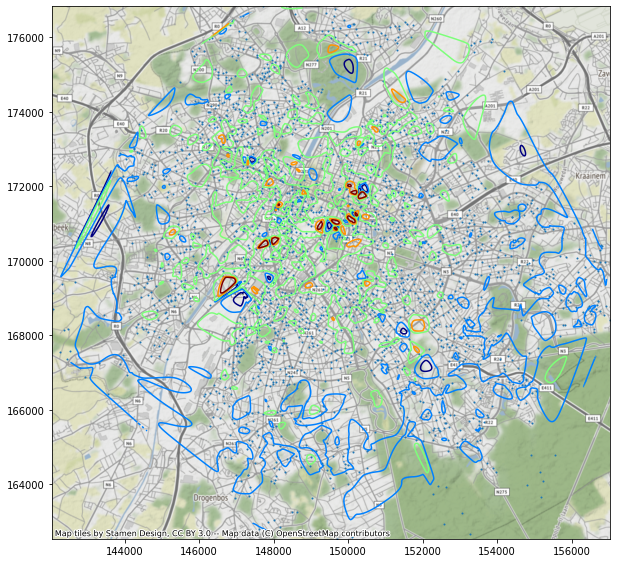

In [28]:
fig, axe = plt.subplots(figsize=(10,10))
gdf.plot(ax=axe, markersize=1)
axe.contour(Xlng, Xlat, yhat, np.linspace(0, 60, 5), cmap="jet")
#axe.set_aspect("equal")
cx.add_basemap(axe, crs=31370)
fig.savefig("bxl.png", dpi=300)

In [17]:
dfx = pd.DataFrame({"x": yhat.ravel()}).dropna()
dfx.describe()#.plot(kind="kde")

,x
count,2.983242e+06
mean,2.011641e+01
std,8.521575e+00
min,-7.616535e+01
25%,1.434076e+01
50%,1.996152e+01
75%,2.519554e+01
max,2.125571e+02


<AxesSubplot:ylabel='Density'>

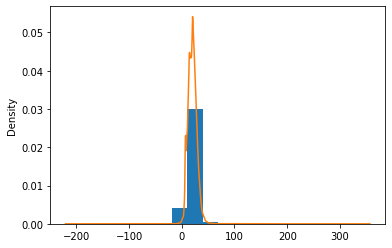

In [18]:
axe = dfx["x"].plot(kind="hist", density=1)
dfx["x"].plot(kind="kde", ax=axe)

<AxesSubplot:ylabel='Density'>

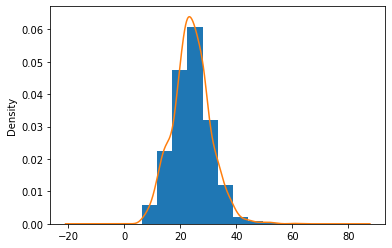

In [19]:
axe = df["no2"].plot(kind="hist", density=1)
df["no2"].plot(kind="kde", ax=axe)

In [20]:
df["no2"].describe()

count    2484.000000
mean       23.982975
std         6.811566
min         6.210000
25%        19.700000
50%        23.805000
75%        28.072500
max        60.500000
Name: no2, dtype: float64